# Proyecto 12

## 1 .- Preparación de datos

### Importación de librerías

In [408]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

### 1.1 - Analisis y examinación de datos

In [409]:
data_full = pd.read_csv('gold_recovery_full.csv')
data_test = pd.read_csv('gold_recovery_test.csv')
data_train = pd.read_csv('gold_recovery_train.csv')

In [410]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [411]:
#Como eran muchos valores nulos en varias columnas quise ver si en algunas columnas era significante la perdida de esos valores
data_full.isna().mean()[data_full.isna().mean() > 0.05]

final.output.recovery                 0.086415
primary_cleaner.input.sulfate         0.070831
primary_cleaner.input.depressant      0.068058
primary_cleaner.input.xanthate        0.050669
rougher.calculation.au_pb_ratio       0.071624
rougher.input.floatbank10_sulfate     0.057272
rougher.input.floatbank11_xanthate    0.099357
rougher.output.recovery               0.137304
rougher.output.tail_ag                0.120488
rougher.output.tail_sol               0.120444
rougher.output.tail_au                0.120444
secondary_cleaner.output.tail_sol     0.097508
dtype: float64

In [412]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [414]:
#Reviso aquellos valores NaN que sean significativos para ver si imputo o elimino
data_test.isna().mean()[data_test.isna().mean() > 0.05]

primary_cleaner.input.sulfate         0.051571
rougher.input.floatbank11_xanthate    0.060280
dtype: float64

In [415]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [416]:
data_train.isna().mean()[data_train.isna().mean() > 0.05]

final.output.recovery                 0.090214
primary_cleaner.input.sulfate         0.077521
primary_cleaner.input.depressant      0.074852
primary_cleaner.input.xanthate        0.058422
rougher.calculation.au_pb_ratio       0.073665
rougher.input.floatbank10_sulfate     0.061922
rougher.input.floatbank11_xanthate    0.112930
rougher.output.recovery               0.152610
rougher.output.tail_ag                0.133452
rougher.output.tail_sol               0.133393
rougher.output.tail_au                0.133393
secondary_cleaner.output.tail_sol     0.117794
dtype: float64

### 1.2 - Comprobación de cálculo de la recuperación.

In [417]:
#Convertir a index la columna de fecha
data_train['date'] = pd.to_datetime(data_train['date'])
data_train = data_train.set_index('date')

In [418]:
# Extraer columnas necesarias
c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']

In [419]:
# Evitar división por cero
recovery_calc = (c * (f - t)) / (f * (c - t)) * 100

In [420]:
recovery_real = data_train['rougher.output.recovery']

In [421]:
# Asegurar que comparamos solo valores válidos
mask = recovery_real.notna() & recovery_calc.notna()
mae = mean_absolute_error(recovery_real[mask], recovery_calc[mask])
print(f"MAE entre recuperación calculada y real: {mae:.4f}")

MAE entre recuperación calculada y real: 0.0000


### 1.3 - Características no disponibles en el conjunto de prueba

In [422]:
# Diferencia de columnas
missing_in_test = data_train.columns.difference(data_test.columns)
print("Columnas presentes en train pero ausentes en test:")

#Ausentes en Test
ausentes = missing_in_test.tolist()
print(ausentes)

Columnas presentes en train pero ausentes en test:
['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_

In [423]:
# Clasificar los tipos de características ausentes

for col in ausentes:
    parts = col.split('.')
    stage, param_type, param_name = parts
    print(f"{col} — tipo: {param_type}")

final.output.concentrate_ag — tipo: output
final.output.concentrate_au — tipo: output
final.output.concentrate_pb — tipo: output
final.output.concentrate_sol — tipo: output
final.output.recovery — tipo: output
final.output.tail_ag — tipo: output
final.output.tail_au — tipo: output
final.output.tail_pb — tipo: output
final.output.tail_sol — tipo: output
primary_cleaner.output.concentrate_ag — tipo: output
primary_cleaner.output.concentrate_au — tipo: output
primary_cleaner.output.concentrate_pb — tipo: output
primary_cleaner.output.concentrate_sol — tipo: output
primary_cleaner.output.tail_ag — tipo: output
primary_cleaner.output.tail_au — tipo: output
primary_cleaner.output.tail_pb — tipo: output
primary_cleaner.output.tail_sol — tipo: output
rougher.calculation.au_pb_ratio — tipo: calculation
rougher.calculation.floatbank10_sulfate_to_au_feed — tipo: calculation
rougher.calculation.floatbank11_sulfate_to_au_feed — tipo: calculation
rougher.calculation.sulfate_to_au_concentrate — tipo:

In [424]:
conteo = {}

# Recorrer la lista
for item in ausentes:
    parts = item.split('.')
    stage, param_type, param_name = parts
    if param_type in conteo:
        conteo[param_type] += 1 
    else:
        conteo[param_type] = 1   

print(conteo)

{'output': 30, 'calculation': 4}


### 1.4 - Procesamiento de datos

In [425]:
# Columnas comunes entre train y test
features = data_train.columns.intersection(data_test.columns).to_list()

# Features seleccionadas previamente
X_train = data_train[features].copy()
X_test = data_test[features].copy()

# Objetivos
y_train = data_train[['rougher.output.recovery', 'final.output.recovery']].copy()


#### Imputar valores faltantes con interpolacion lineal

In [426]:
# Interpolación temporal
X_train = X_train.interpolate(method='linear')
X_train = X_train.fillna(method='ffill').fillna(method='bfill')

X_test = X_test.interpolate(method='linear')
X_test = X_test.fillna(method='ffill').fillna(method='bfill')


C:\Users\luism\AppData\Local\Temp\ipykernel_6628\1976259215.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.fillna(method='ffill').fillna(method='bfill')
C:\Users\luism\AppData\Local\Temp\ipykernel_6628\1976259215.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method='ffill').fillna(method='bfill')


#### Estandarización de datos

In [428]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2 .- Análisis de datos

### 2.1 - Cambio de concentración de metales (Au, Ag, Pb) 

In [429]:
# Filtrar columnas por metal y buscamos todas las que tengan que ver con la etapa antes y despues de la purificación para ver como se comporta
metals = ['au', 'ag', 'pb']
stages = ['rougher.input', 'rougher.output', 'final.output']

#Hacemos una lista de las columnas
metal_cols = [col for col in data_train.columns #Recorremos cada elemento de los nombres de las columnas
              if any(metal in col for metal in metals) #Revisamos si el nombre de la columna contiene alguno de los metales
              and any(stage in col for stage in stages)] #Y revisamos que tambien forme parte del proceso de filtrado 
              # Si si se cumplen las dos condiciones da True y se añade a la lista
print("Columnas seleccionadas:")
print(data_train[metal_cols].info())

Columnas seleccionadas:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   final.output.concentrate_ag    16788 non-null  float64
 1   final.output.concentrate_pb    16788 non-null  float64
 2   final.output.concentrate_au    16789 non-null  float64
 3   final.output.tail_ag           16794 non-null  float64
 4   final.output.tail_pb           16677 non-null  float64
 5   final.output.tail_au           16794 non-null  float64
 6   rougher.input.feed_ag          16778 non-null  float64
 7   rougher.input.feed_pb          16632 non-null  float64
 8   rougher.input.feed_au          16777 non-null  float64
 9   rougher.output.concentrate_ag  16778 non-null  float64
 10  rougher.output.concentrate_pb  16778 non-null  float64
 11  rougher.output.concentrate_au  16778 non-null  

In [430]:
#Ya teniendo las columnas que son parte del proceso de purificación las extramos del dataframe dependiendo el metal
def plot_metal_concentrations(data, metal_cols, metal, window=50):
    relevant_cols = [col for col in metal_cols if f'_{metal}' in col] #Primero buscamos entre las columnas relevantes el metal que vamos a graficar

    plt.figure(figsize=(10, 5)) 
    for col in relevant_cols: #Luego de tener las columnas del metal en especifico nos deshacemos de los Nan y con rolling().mean()
        series = data[col].dropna().rolling(window=window).mean()   #Hacemos una ventana de 50 para calcular el promedio
        plt.plot(series, label=col)                                 #Así tenemos menos puntos pero menos ruido y vemos más clara la gráfica
    plt.title(f'Concentración de {metal.upper()} a lo largo del tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Concentración')
    plt.legend()
    plt.tight_layout()
    plt.show()

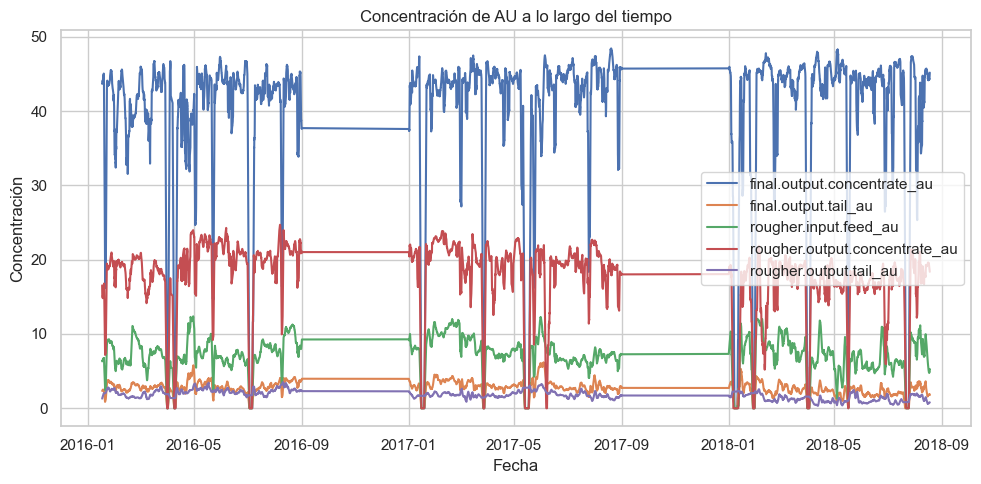

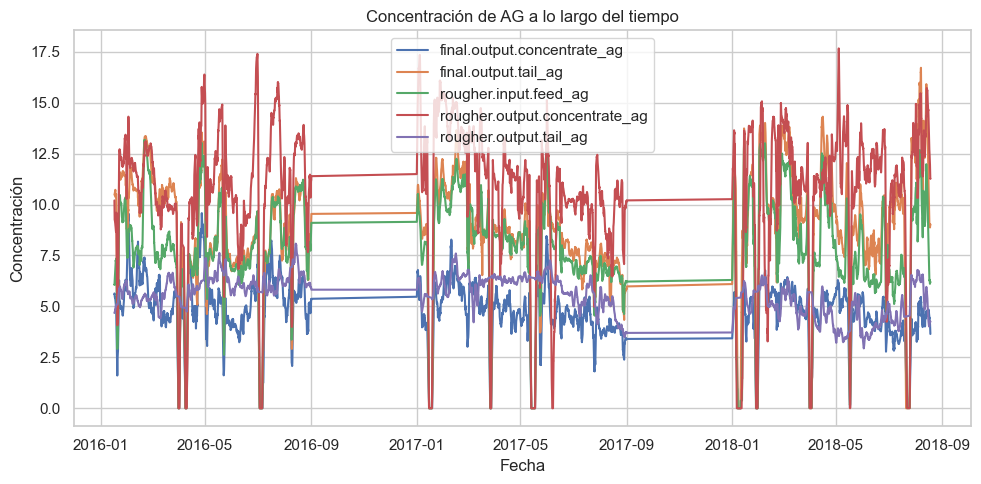

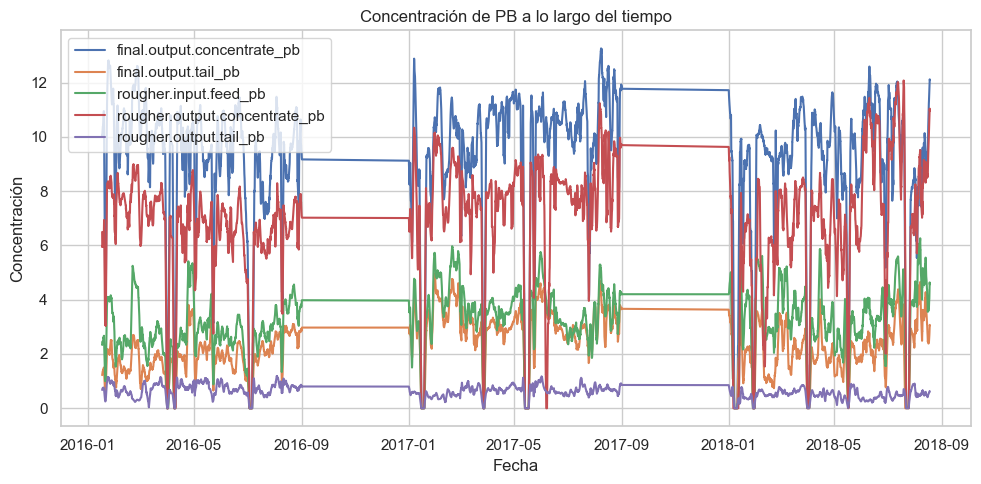

In [431]:
plot_metal_concentrations(data_train, metal_cols, 'au')  # Para oro
plot_metal_concentrations(data_train, metal_cols, 'ag')  # Para plata
plot_metal_concentrations(data_train, metal_cols, 'pb')  # Para plomo

#### Observaciones
Podemos ver que en la etapa final con final.output.concentrate, con lo que respecta al Oro y al plomo tienen altos niveles de concentración a diferencia de la Plata

### 2.2 Comparar distribuciones del tamaño de las particulas

In [432]:
cols_size = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

for col in cols_size:
    if col in data_train.columns[0:4] and col in data_test.columns[0:4]:
        print(col)

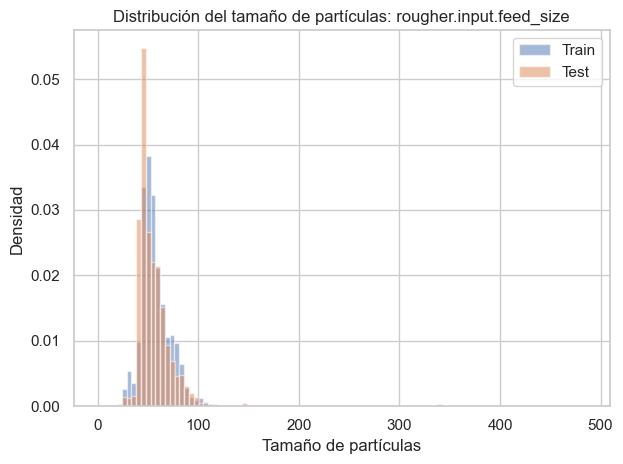


 Estadísticas para 'rougher.input.feed_size':
Train Media: 58.68, Desviación estándar: 23.92
Test Media: 55.94, Desviación estándar: 22.72


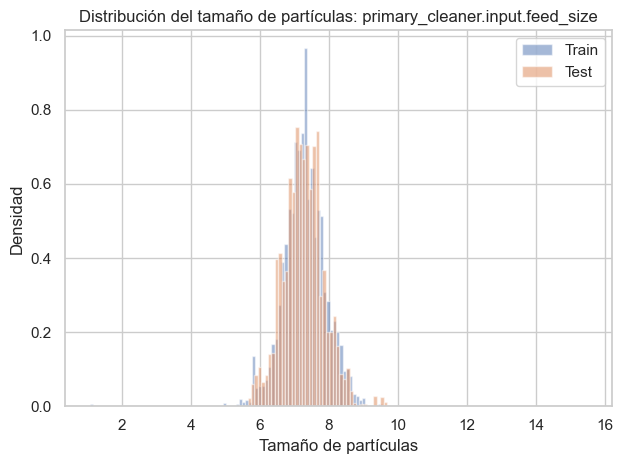


 Estadísticas para 'primary_cleaner.input.feed_size':
Train Media: 7.30, Desviación estándar: 0.62
Test Media: 7.26, Desviación estándar: 0.61


In [433]:
# Seleccionamos las columnas que contienen información sobre el tamaño de las partículas que entran a cada etapa
cols_size = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

for col in cols_size:
    if col in data_train.columns and col in data_test.columns: #Comparamos y vemos que este en ambos conjuntos de datos
        data_train[col].hist(alpha=0.5, label='Train', bins=100, density=True) #Construimos dos histogramas para ver la varianbilidad de los datos
        data_test[col].hist(alpha=0.5, label='Test', bins=100, density=True)
        plt.title(f'Distribución del tamaño de partículas: {col}')
        plt.xlabel('Tamaño de partículas')
        plt.ylabel('Densidad')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"\n Estadísticas para '{col}':")
        media_train = data_train[col].mean()
        std_train = data_train[col].std()
        media_test = data_test[col].mean()
        std_test = data_test[col].std()

        print(f"Train Media: {media_train:.2f}, Desviación estándar: {std_train:.2f}")
        print(f"Test Media: {media_test:.2f}, Desviación estándar: {std_test:.2f}")
    else:
        print(f"La columna '{col}' no está en ambos conjuntos.")


#### Observaciones

La forma de los histogramas es muy similar y parecen concentrarse cerca de un valor y tener poca variabilidad, lo cual nos dice que el tamaño de las partículas en train y test tiene una distribución casi idéntica y estrecha, lo cual es una señal positiva para el entrenamiento del modelo. Ademas al calcular la media y desviación logramos validar que no hay diferencias significativas entre los conjuntos de entrenamiento y prueba en cuanto al tamaño de partículas.

### 2.3 - Concentracion total de las sustancias en diferentes etapas.

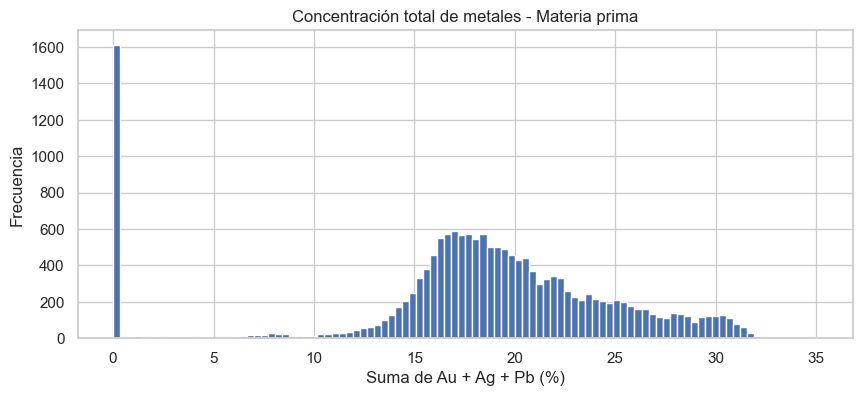

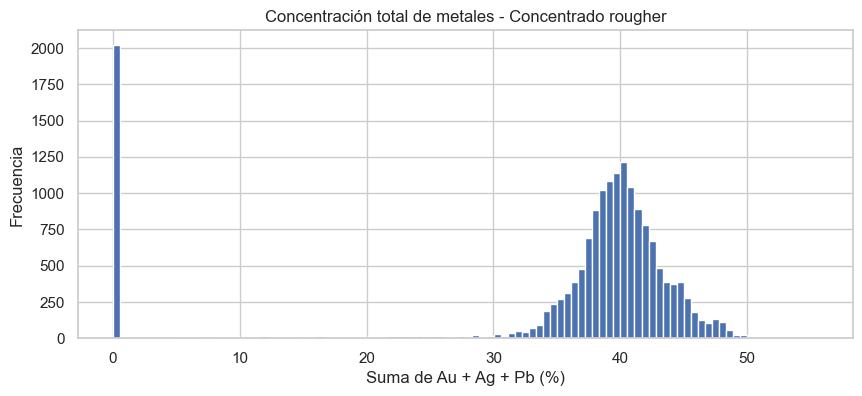

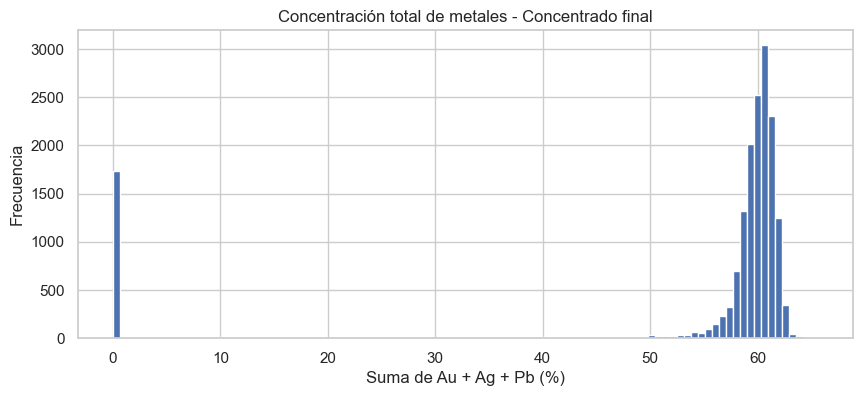

In [436]:
# Etapas y sufijos correctos
etapas = {
    'Materia prima': 'rougher.input.feed_',
    'Concentrado rougher': 'rougher.output.concentrate_',
    'Concentrado final': 'final.output.concentrate_'
}

metales = ['au', 'ag', 'pb']

for nombre_etapa, prefijo_col in etapas.items(): #Iteramos sobre las tres etapas del proceso
    #Luego hacemos una lista con los tres tipos de metales para cada proceso y agregamos una condicion en caso que no exista el nombre de una columna
    columnas = [f'{prefijo_col}{metal}' for metal in metales if f'{prefijo_col}{metal}' in data_train.columns]

    if columnas:
        concentracion_total = data_train[columnas].sum(axis=1) #Sumamos los tres metales para cada etapa del proceso
        plt.figure(figsize=(10, 4))
        concentracion_total.hist(bins=100) #Construimos el histograma del total de concentración de los tres metales en cada proceso 
        plt.title(f'Concentración total de metales - {nombre_etapa}')
        plt.xlabel('Suma de Au + Ag + Pb (%)')
        plt.ylabel('Frecuencia')
        plt.show()

        # Identificar valores anómalos
        anomalias = concentracion_total[(concentracion_total <= 0) | (concentracion_total > 100)]
    else:
        print(f"No se encontraron columnas para {nombre_etapa}")


#### Observaciones

Podemos ver como por cada etapa que va pasando en el proceso la concentración es cada vez mayor, los valores que estan en 0 o cerca de 0 puede deverse a valores Nan o valores faltantes ya que se tomaron en cuenta los datos sin estandarizar, ya que si hubieramos estandarizado y luego gráficado, las graficas se verían totalmente diferentes. Los datos imputados y estandarizados solo se usaran en el modelaje.

## 3.- Construcción del modelo

### 3.1 - Función para calcular el valor final de sMAPE

In [437]:
#Formula para calcular Symmetric Mean Absolute Percentage Error (sMAPE)
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [438]:
# Función para metrica compuesta final
def final_score(y_true, y_pred):
    smape_rougher = smape(y_true[:, 0], y_pred[:, 0])
    smape_final = smape(y_true[:, 1], y_pred[:, 1])
    return 0.25 * smape_rougher + 0.75 * smape_final


### 3.2 - Entrenamiento de diferentes modelos.

In [439]:
#Recordatorio del codigo previo usado para seleccionar target y features
('''
# Features seleccionadas previamente
X_train = data_train[features].copy()
X_test = data_test[features].copy()

#Features escalonados
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

# Objetivos
y_train = data_train[['rougher.output.recovery', 'final.output.recovery']].copy()''')

print("Valores nulos:",y_train['rougher.output.recovery'].isna().mean())
print("Valores nulos:",y_train['final.output.recovery'].isna().mean())

Valores nulos: 0.1526097271648873
Valores nulos: 0.0902135231316726


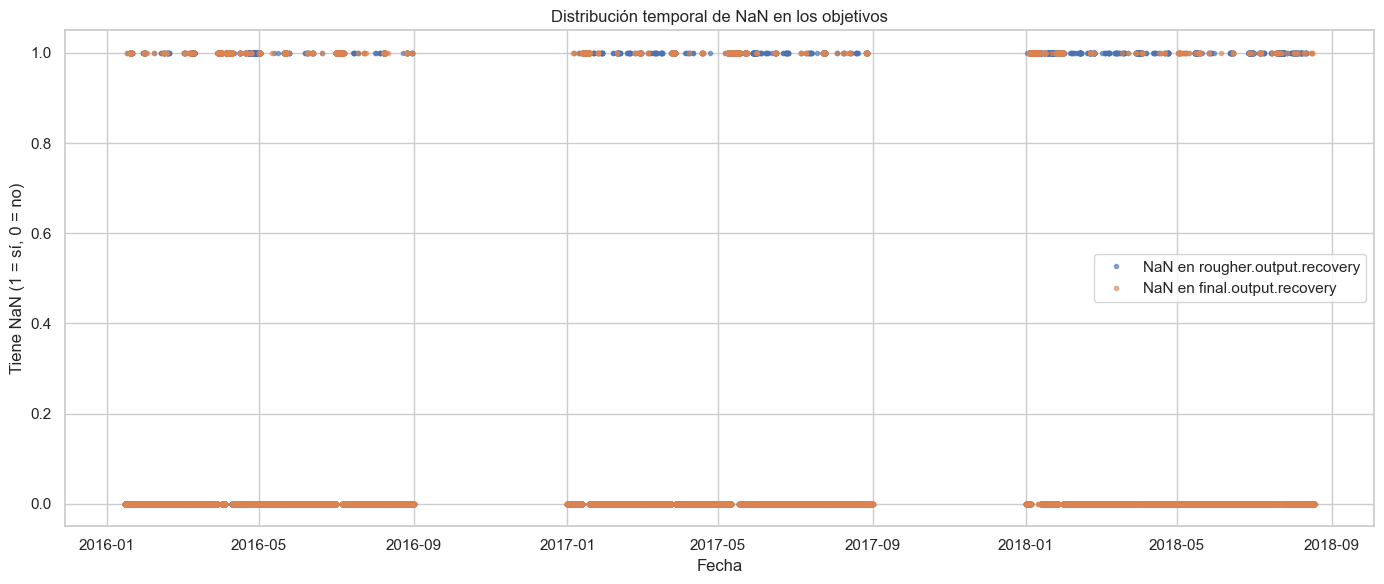

In [440]:
#Antes del modelado hay que ver que hacer con los valores nulos del target, ya que si tienen un porcentaje significante
#Por lo que hay que ver si tienen algún patron o son al azar

# Crear máscaras de NaN para cada objetivo
nan_rougher = y_train['rougher.output.recovery'].isna()
nan_final = y_train['final.output.recovery'].isna()

# Graficar ambos
plt.figure(figsize=(14, 6))

plt.plot(nan_rougher.astype(int), label='NaN en rougher.output.recovery', alpha=0.6, marker='.', linestyle='None')
plt.plot(nan_final.astype(int), label='NaN en final.output.recovery', alpha=0.6, marker='.', linestyle='None')

plt.title('Distribución temporal de NaN en los objetivos')
plt.xlabel('Fecha')
plt.ylabel('Tiene NaN (1 = sí, 0 = no)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Observacion

A pesar de haber valores nulos en los target aun se comportan de manera aleatoria por lo que se toma la decisión de eliminarlos.

In [460]:
# Se crea una máscara para no tomar en cuenta las filas con NaN en los objetivos
target_mask = ~y_train.isna().any(axis=1)

# Aplicar la máscara tanto a X como a y y obtenemos nuevos features y target train
X_train_filtered = X_train_scaled[target_mask]
y_train_filtered = y_train[target_mask]
#X_test_filtered = X_test_scaled[target_mask]

# Confirmamos formas finales
print("Conjuntos listos:")
print(f"X_train_filtered shape: {X_train_filtered.shape}")
print(f"y_train_filtered shape: {y_train_filtered.shape}")


Conjuntos listos:
X_train_filtered shape: (14149, 52)
y_train_filtered shape: (14149, 2)


In [ ]:
# Crear modelos para cada objetivo
model_rougher = RandomForestRegressor(random_state=42, n_estimators=30, n_jobs=-1)
model_final = RandomForestRegressor(random_state=42, n_estimators=30, n_jobs=-1)

# Entrenar modelos en todos los datos disponibles (sin validación cruzada aquí)
model_rougher.fit(X_train_filtered, y_train_filtered['rougher.output.recovery'])
model_final.fit(X_train_filtered, y_train_filtered['final.output.recovery'])

# Validación cruzada (3-fold)
pred_rougher = cross_val_predict(model_rougher, X_train_filtered, y_train_filtered['rougher.output.recovery'], cv=3)
pred_final = cross_val_predict(model_final, X_train_filtered, y_train_filtered['final.output.recovery'], cv=3)

# Unir predicciones
predictions = np.column_stack((pred_rougher, pred_final)) #Guardamos las predicciones de rougher y final
true_values = y_train_filtered.to_numpy()

# Calcular puntuación final
score = final_score(true_values, predictions) #Aplicamos las funciones de final score que dentro tiene smape
print(f"Puntuación final con RandomForest: {score:.4f}")


Puntuación final con RandomForest: 13.3873


In [444]:
# Inicializamos los modelos para cada objetivo
gbr_rougher = GradientBoostingRegressor(n_estimators=30, random_state=42)
gbr_final = GradientBoostingRegressor(n_estimators=30, random_state=42)

# Entrenamos los modelos con los datos filtrados
gbr_rougher.fit(X_train_filtered, y_train_filtered['rougher.output.recovery'])
gbr_final.fit(X_train_filtered, y_train_filtered['final.output.recovery'])

# Validación cruzada (3-fold) y predicciones
gbr_pred_rougher = cross_val_predict(gbr_rougher, X_train_filtered, y_train_filtered['rougher.output.recovery'], cv=3)
gbr_pred_final = cross_val_predict(gbr_final, X_train_filtered, y_train_filtered['final.output.recovery'], cv=3)

# Calculamos la métrica sMAPE combinada
gbr_score = final_score(
    y_true = y_train_filtered[['rougher.output.recovery', 'final.output.recovery']].values,
    y_pred = np.column_stack([gbr_pred_rougher, gbr_pred_final])
)

print(f"Puntuación final con GradientBoosting: {gbr_score:.4f}")


Puntuación final con GradientBoosting: 12.0383


## Conclusión general

Para este proyecto hubo que tomar en cuenta y analizar el proceso que nos proporcionó la empresa, el análisis de datos nos mostro que el conjunto de datos tenian similitudes tal cual como los nombres de las columnas y también nos mostró como es que se comportan los datos conforme cambia el proceso por el cual pasa el material, por ello es que veíamos como cada vez era menos la varianza entre el nivel de concentración de los metales.

De los modelos propuestos el mejor resultado obtenido fue utilizando GradientBoostingRegressor que funciona muy bien para problemas de regresión no lineales y complejos. Donde ademas el error relativo nio dio un 12% lo que significa que en nuestro modelo hay un 12% de probabilidades de que nuestro modelo se equivoque pero que aun así sigue siendo la mejor opcion.